# Test Modeling with stock_id == 0

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import (RandomizedSearchCV, TimeSeriesSplit, cross_val_score, train_test_split)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Dense, Dropout, LSTM, Attention, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LeakyReLU, PReLU
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, load_model
import keras_tuner
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.activations import elu, relu

from tensorflow import keras
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

Using TensorFlow backend


In [19]:
dfAll = pd.read_csv('train.csv')
df = dfAll[dfAll.stock_id == 0]

In [11]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [38]:
dfUse = df.copy()
dropping = ['stock_id', 'time_id', 'date_id']
dfUse.sort_index(level=['date_id', 'time_id'], inplace=True)
dfUse.drop(dropping, inplace=True, axis=1)
dfUse.set_index('row_id', inplace=True)

In [42]:
dfUse.fillna(0, inplace=True)

In [43]:
dfUse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26455 entries, 0_0_0 to 480_540_0
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   seconds_in_bucket        26455 non-null  int64  
 1   imbalance_size           26455 non-null  float64
 2   imbalance_buy_sell_flag  26455 non-null  int64  
 3   reference_price          26455 non-null  float64
 4   matched_size             26455 non-null  float64
 5   far_price                26455 non-null  float64
 6   near_price               26455 non-null  float64
 7   bid_price                26455 non-null  float64
 8   bid_size                 26455 non-null  float64
 9   ask_price                26455 non-null  float64
 10  ask_size                 26455 non-null  float64
 11  wap                      26455 non-null  float64
 12  target                   26455 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 2.8+ MB


In [80]:
dfAdj = dfUse.copy()
# Assuming you have two additional features at columns 2 and 3
features_to_use = list(range(0, 12))
training_set = dfAdj.iloc[:, features_to_use].values
y_set = dfAdj.iloc[:,-1].values.reshape(-1, 1)

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled = np.concatenate((y_set, training_set_scaled), axis=1)

X = []
y = []

# Assuming you want to use 60 previous time steps for prediction
for i in range(112, len(training_set_scaled)):
    X.append(training_set_scaled[i-112:i, 1:])
    y.append(training_set_scaled[i, 0])

X, y = np.array(X), np.array(y)

# # Split the data into training and testing sets (80% training, 20% testing)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
# Reshape the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = testX.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2])

In [82]:
model = Sequential()
# softplus, LeakyReLU(alpha=0.005), elu, PReLU, selu, relu
l = 0.0001
act = LeakyReLU(alpha=0.0001)
# model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation=act, return_sequences=True)))
# model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=2, activation=act))
# model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32, activation=act, return_sequences=False))
# model.add(Dense(32, activation=act))
# model.add(PReLU())
model.add(Dense(1, activation=act))
# LeakyReLU(alpha=0.0008)
optimizer = keras.optimizers.Adam(learning_rate=l)
# optimizer = keras.optimizers.SGD(learning_rate=0.00001, momentum=0.25)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.00003, rho=0.9)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# history = model.fit(X_train, y_train, epochs=100, batch_size=30, verbose=1, shuffle=False, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, shuffle=False, validation_data=(X_test, y_test), callbacks=[early_stopping])

y_pred = model.predict(X_test)

Epoch 1/20
458/749 [=================>............] - ETA: 22s - loss: 40.3841

KeyboardInterrupt: 

Mean Squared Error (MSE): 25.82396380616801
Mean Absolute Error (MAE): 3.834679691583171
R-squared (R2): 0.0011733727877319966


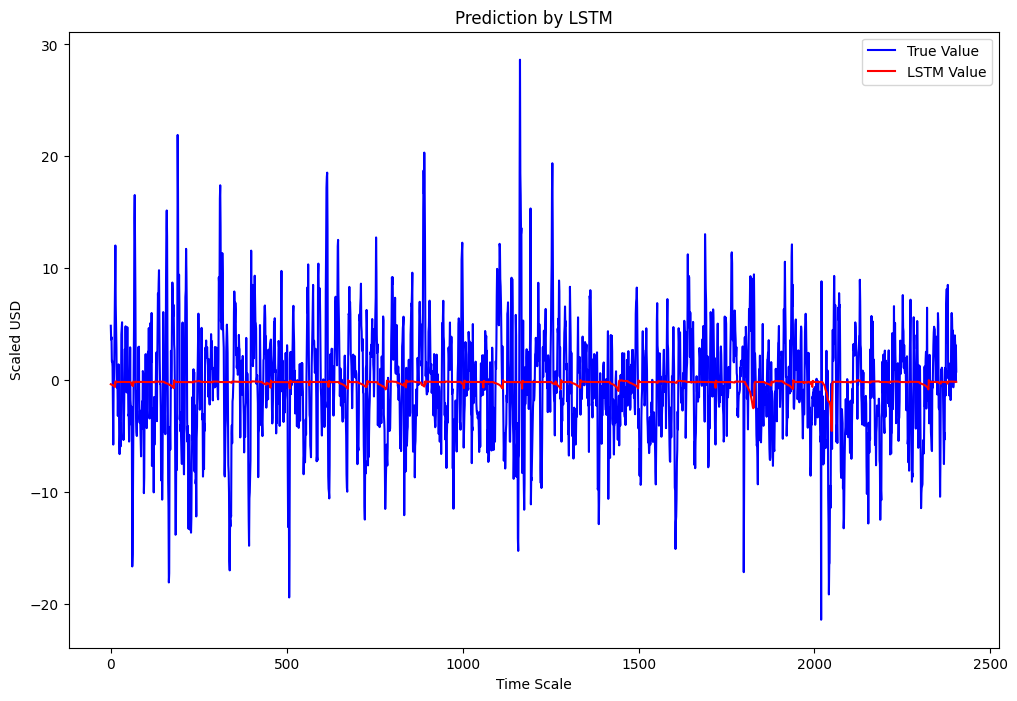

In [75]:
# Assuming 'y_true' is your true target values and 'y_pred' is your predicted values
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

#Predicted vs True Adj Close Value – LSTM
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True Value', color='blue')
plt.plot(y_pred, label='LSTM Value', color='red')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()